In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# 1. Load data
df = pd.read_csv("Tweets.csv")
df = df[['text', 'airline_sentiment', 'airline', 'negativereason']]
df = df.dropna(subset=['text', 'airline_sentiment'])

In [3]:
# 2. Text cleaning (same as others)
def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^A-Za-z\s]", " ", text)
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['negativereason'] = df['negativereason'].fillna("")
df['full_text'] = (df['text'] + " " + df['negativereason']).apply(clean_text)

In [4]:
# 3. Train / test split
X = df['full_text']
y = df['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
# 4. TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

In [6]:
# 5. SVM model (Linear SVC)
svm_clf = LinearSVC()
svm_clf.fit(X_train_tfidf, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [7]:
# 6. Evaluation
y_pred_svm = svm_clf.predict(X_test_tfidf)

print("=== SVM Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print()
print(classification_report(y_test, y_pred_svm))

=== SVM Performance ===
Accuracy: 0.9279371584699454

              precision    recall  f1-score   support

    negative       0.99      1.00      0.99      1835
     neutral       0.82      0.87      0.84       620
    positive       0.84      0.72      0.77       473

    accuracy                           0.93      2928
   macro avg       0.88      0.86      0.87      2928
weighted avg       0.93      0.93      0.93      2928



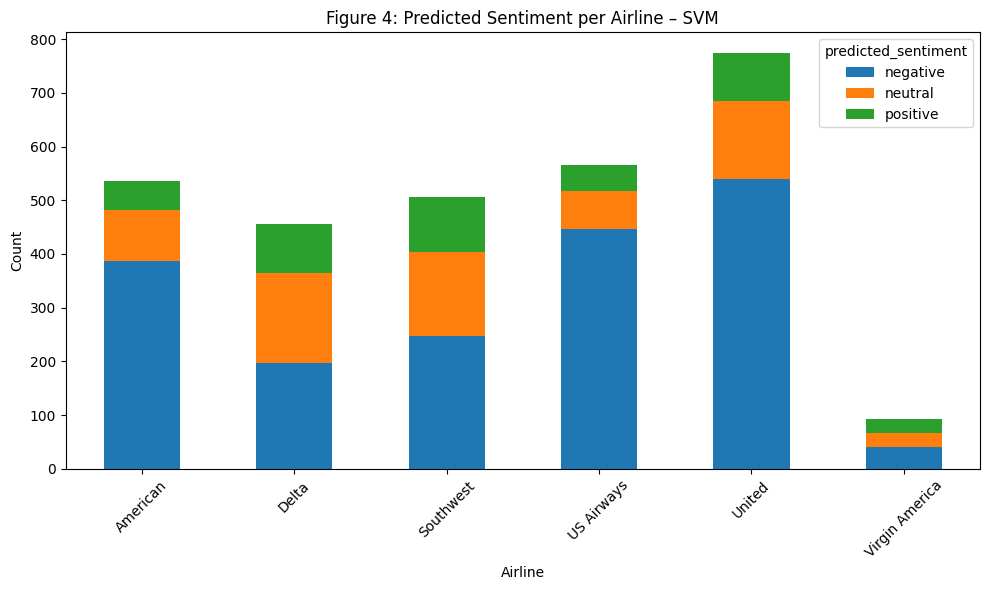

In [8]:
# 7. Airline-level sentiment distribution 
X_test_df = X_test.to_frame()
X_test_df['true_sentiment'] = y_test.values
X_test_df['predicted_sentiment'] = y_pred_svm
X_test_df['airline'] = df.loc[X_test.index, 'airline'].values

airline_sentiment_svm = (
    X_test_df
    .groupby(['airline', 'predicted_sentiment'])
    .size()
    .unstack(fill_value=0)
)

airline_sentiment_svm.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title("Figure 4: Predicted Sentiment per Airline – SVM")
plt.xlabel("Airline")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
labels = ['negative', 'neutral', 'positive']

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=labels, yticklabels=labels,
                cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()

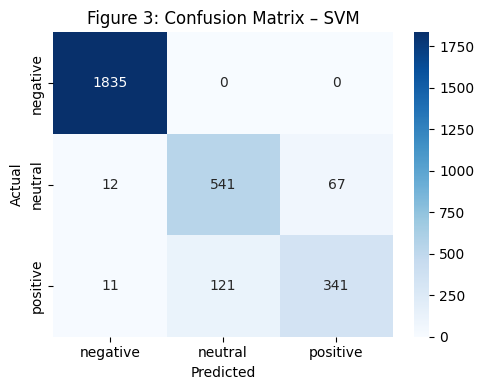

In [10]:
plot_confusion_matrix(y_test, y_pred_svm, "Figure 3: Confusion Matrix – SVM")